In [1]:
cd ../../

/home/bluesun/PycharmProjects/tmp/BERTAP_v2


/home/bluesun/anaconda3/envs/rl/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pickle
import numpy as np
import jax, jax.numpy as jp
import flax, optax
from flax.training.common_utils import shard, shard_prng_key
from flax.jax_utils import pad_shard_unpad

from src import BASE_DIR
from src.models.vae import VQVAE
from src.common.configs import TotalConfigs, DatasetConfig, ModelConfig, TrainConfig
from src.datasets import AntDataLoader, AntNormalizer, make_env
from src.utils.train_state import TrainState
from src.utils.ant_viz import GoalReachingAnt
from src.utils.logging_utils import Logger, compare_recons
from src.utils.context import make_rngs, save_state
from src.scripts.vae_prepare import prepare_config_dataset, prepare_states
from src.scripts.batch_samplers import vae_batch_sampler

import wandb
from boxprint import bprint
from functools import partial
from pathlib import Path
from tqdm import tqdm
from typing import Dict, List, Tuple

/home/bluesun/anaconda3/envs/rl/lib/python3.11/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:48:36
/home/bluesun/anaconda3/envs/rl/lib/python3.11/site-packages/pybullet_envs/env_bases.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/bluesun/anaconda3/envs/rl/lib/python3.11/site-packages/pkg_resources/__init__.py:2832: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to

In [3]:
import chex
env_name = "antmaze-large-play-v2"
model_def = VQVAE

pmap = True
log_interval = 20
save_interval = 2000
eval_freq = 2
use_wandb = False
kwargs = {
    "model": {},
    "dataset": {"goal_conditioned": True, "hierarchical_goal": False, "p_true_goal": 1.0, "p_sub_goal": 0.0},
    "train": {}
}

seq_len = 64
latent_step=4
batch_size=256
n_epochs=10


In [4]:
# Prepare config and dataset ========
seq_len = 64
dataloader, configs = prepare_config_dataset(env_name, seq_len, latent_step, batch_size, n_epochs, **kwargs)
render_env = GoalReachingAnt(env_name)
n_devices = jax.device_count()

# Data sampler ========
sample_batch_fn, (normalizer, splits) = vae_batch_sampler(dataloader, batch_size, normalize=True)

def check(pos, goal):
    import matplotlib.pyplot as plt
    render_env.draw()
    c = np.linspace(0, 1, len(pos))
    plt.scatter(pos[..., 0], pos[..., 1], s=10, alpha=0.5, zorder=1, c=c)
    plt.scatter(goal[..., 0], goal[..., 1], s=100, c='r', edgecolors='k', marker='*', alpha=0.8, zorder=3)
    plt.show()

/home/bluesun/anaconda3/envs/rl/lib/python3.11/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Target Goal:  (32.666131143637415, 24.513526574967067)
Loading dataset...


load datafile: 100%|██████████| 8/8 [00:01<00:00,  7.30it/s]


==== [Fixing terminal for AntMaze] ====
Target Goal:  (32.75958616538049, 25.211320164701082)


In [5]:
def check_traj(i):
    eval_starts = np.arange(4) * dataloader.seq_len + i
    eval_batch = sample_batch_fn(starts=eval_starts, pmap=False)
    denorm_keys = ("goals", "observations", "actions")
    eval_batch = normalizer.denormalize_concat(eval_batch["traj_seq"], keys=denorm_keys, splits=splits)
    eval_batch = eval_batch.reshape(-1, 40)
    check(eval_batch[:, 2:4], eval_batch[:, :2])
    

In [6]:
eval_starts = np.arange(4) * dataloader.seq_len + 20 * 100
eval_batch = sample_batch_fn(starts=eval_starts, pmap=False)
eval_batch_unnorm = vae_batch_sampler(dataloader, batch_size, normalize=False)[0](starts=eval_starts, pmap=False)

In [7]:
denorm_keys = ("goals", "observations", "actions")
eval_batch = normalizer.denormalize_concat(eval_batch['traj_seq'], denorm_keys, splits)

In [8]:
eval_batch = eval_batch.reshape(-1, 40)

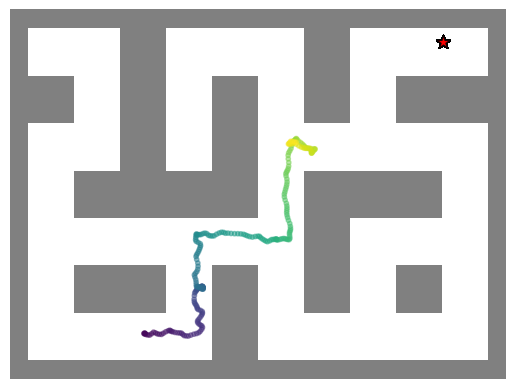

In [9]:
check(eval_batch[:, 2:4], eval_batch[:, :2])

In [12]:
eval_batch.shape

(4, 64, 40)

In [25]:
pwd

'/home/bluesun/PycharmProjects/tmp/BERTAP_v2'

In [36]:
import matplotlib.pyplot as plt
from pathlib import Path
plt.close()

path = Path("./traj_test/").absolute()
print(path)
path.mkdir(exist_ok=True)

def plot_traj(i):
    ids = np.arange(dataloader.terminal_ids[i], dataloader.terminal_ids[i+1]) + 1
    traj = dataloader.dataset.sample(index=ids)
    pos = traj["observations"][:, :2]
    goals = traj["goals"]
    
    render_env.draw()
    plt.title(f"Trajectory {i}")
    c = np.linspace(0, 1, len(pos))
    plt.scatter(pos[:, 0], pos[:, 1], s=10, alpha=0.5, zorder=1, c=c)
    plt.scatter(goals[:, 0], goals[:, 1], s=100, c='r', edgecolors='k', marker='*', alpha=0.8, zorder=3)
    
    plt.savefig(str(path / f"traj_{i}.png"))
    plt.close()

/home/bluesun/PycharmProjects/tmp/BERTAP_v2/traj_test


In [37]:
from tqdm import tqdm
for i in tqdm(range(100)):
    plot_traj(i)

100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


In [31]:
dataloader.terminal_ids[20]

20999

In [32]:
i = 20
ids = np.arange(dataloader.terminal_ids[i], dataloader.terminal_ids[i+1])
traj = dataloader.dataset.sample(index=ids)
pos = traj["observations"][:, :2]
goals = traj["goals"]

In [33]:
goals.shape

(1000, 2)

In [35]:
dataloader.terminal_ids[20]

20999